<h1>Examining the Balance of Exploration and Exploitation in Reinforcement Learning Using Q learning</h1>

In this study, I investigate the contrasting effects of prioritizing exploration versus exploitation in the reinforcement learning (RL) paradigm, using the "CartPole-v1" environment from OpenAI Gym. By modulating the exploration and exploitation coefficients, I explore the ideal balance for an agent to maximize its cumulative reward.

<b> What is the cartpole environment?</b>

 Ss a simple environment where the goal is to keep a pole balanced upright on a moving cart. The cart can only move left or right along a straight track, and the game is controlled by deciding which direction to move the cart. The pole is attached to the cart at its bottom and will fall over if it's not kept balanced. Each moment the pole stays upright, the player earns points.

<b> Q Learning </b>: Is a model-free reinforcement learning algorithm that seeks to learn the value of an action in a particular state. It uses a Q-table where each entry represents an estimated cumulative reward for taking a given action in a given state and then following the optimal policy thereafter.

<h2>Code Structure and Methods</h2>

<li><b>Discretization:</b> The discretize method processes the continuous observation space into discrete bins, which simplifies the learning problem.Given that Q-learning typically requires a discrete state space and the CartPole environment has a continuous state space, the code uses KBinsDiscretizer to convert continuous state variables into discrete bins. This transformation allows the Q-learning algorithm to be applied effectively by categorizing continuous ranges into discrete states.
<br></br>

<li><b>Policy:</b> The policy method determines the agent's action based on the current state by selecting the action with the highest Q-value in the Q-table.
<br></br>
<li><b>Exploration and Learning Rates:</b> The exploration_rate and learning_rate methods calculate the rate of exploration and learning, respectively. These rates decay over time, allowing the agent to transition from exploration to exploitation.
<br></br>
<li><b>Q-value Update: </b>The update_Q_value method updates the Q-value in the Q-table based on the received reward and the maximum predicted Q-value for the next state.The code tracks the total reward accumulated in each episode, which is a common method to evaluate the agent's performance over time. This metric helps in assessing how well the agent learns to balance the pole, with higher total rewards indicating better performance.
<br></br>
<li><b>Simulation: </b>The run_simulation method executes the RL loop, where the agent interacts with the environment across episodes, applying actions and updating the Q-table. It also records the reward data for analysis.
<br></br>
<li><b>Plotting Results:</b> The plot_results method generates plots of the rewards per episode, along with a rolling average of the rewards over the last 100 episodes. This visualization aids in interpreting the agent's performance over time.
<br></br>
<li><b>Simulation Execution:</b> The run_simulation method is called on both instances, which kicks off the experiments. The rewards and trends observed in these runs form the basis of my comparative analysis.

In [ ]:
import gym
import numpy as np
from math import radians, log10
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
import cv2
import time

class CartPoleAgent:
    def __init__(self, learning_coeff, exploration_coeff, seed=42, n_episodes=5000,graph_title="Reward vs Time",folder_name=""):
        self.learning_coeff = learning_coeff
        self.exploration_coeff = exploration_coeff
        self.seed = seed
        self.n_episodes = n_episodes
        self.graph_title = graph_title
        self.folder_name= folder_name

        self.env = gym.make("CartPole-v1", render_mode='rgb_array')
        self.env.action_space.seed(self.seed)
        np.random.seed(self.seed)
        
        self.n_bins = (12, 12, 12, 12)
        self.lower_bounds = [self.env.observation_space.low[0], -0.25, self.env.observation_space.low[2], -radians(50)]
        self.upper_bounds = [self.env.observation_space.high[0], 0.25, self.env.observation_space.high[2], radians(50)]
        self.Q_table = np.zeros(self.n_bins + (self.env.action_space.n,))
        
        self.graph_x = np.arange(self.n_episodes)
        self.graph_y = np.zeros(self.n_episodes)
    
    def discretize(self, observation):
        cart_position, cart_velocity, angle, pole_velocity = observation
        estimator = KBinsDiscretizer(n_bins=self.n_bins, encode='ordinal', strategy='uniform')
        estimator.fit([self.lower_bounds, self.upper_bounds])
        return tuple(map(int, estimator.transform([[cart_position, cart_velocity, angle, pole_velocity]])[0]))

    def policy(self, state):
        return np.argmax(self.Q_table[state])

    def exploration_rate(self, episode, min_rate=0.05):
        return max(min_rate, 1.0 - log10((episode + 1) / self.exploration_coeff))

    def learning_rate(self, episode, min_rate=0.01):
        return max(min_rate, 1.0 - log10((episode + 1) / self.learning_coeff))

    def update_Q_value(self, reward, new_state, discount_factor=1.0):
        future_value = np.max(self.Q_table[new_state])
        return reward + discount_factor * future_value

    def run_simulation(self):
        total_time = 0
        successful_episodes = 0 
        max_steps = 500 
        cumulative_steps = 0  
        
        for episode in range(self.n_episodes):
            observation, info = self.env.reset()
            state, done, truncated = self.discretize(observation), False, False
            total_reward = 0
            step_count = 0  
            
            # Only record every 500 episodes
            record_video = (episode % 500 == 0)
            frames = [] if record_video else None

            while not done and not truncated:
                start_time = time.time()
                action = self.policy(state) if np.random.random() > self.exploration_rate(episode) else self.env.action_space.sample()
                observation, reward, done, truncated, info = self.env.step(action)
                new_state = self.discretize(observation)
                step_count += 1  

                if record_video:
                    frames.append(self.env.render())

                # Update Q-table
                lr = self.learning_rate(episode)
                new_q_value = self.update_Q_value(reward, new_state)
                self.Q_table[state][action] = (1 - lr) * self.Q_table[state][action] + lr * new_q_value

                state = new_state
                total_reward += reward

                end_time = time.time()
                total_time += end_time - start_time

            # Track cumulative steps
            cumulative_steps += step_count

            # Check if the episode was successful
            if step_count >= max_steps:
                successful_episodes += 1
            
            # Print results every 100 episodes
            if (episode + 1) % 100 == 0:
                average_steps = cumulative_steps / 100
                print(f"Episode {episode + 1}: Steps taken = {step_count}, Total reward = {total_reward}, Average steps (last 100) = {average_steps:.2f}")
                cumulative_steps = 0  

            # Export video
            if record_video and frames:
                height, width, _ = frames[0].shape
                video_writer = cv2.VideoWriter(f'{self.folder_name}/cartpole_episode_{episode}.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
                for frame in frames:
                    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
                video_writer.release()
            
            self.graph_y[episode] = total_reward
        
        # Calculate success rate
        success_rate = (successful_episodes / self.n_episodes) * 100
        print(f"Success rate: {success_rate:.2f}% of episodes reached the maximum steps.")
        
        self.plot_results()
        self.env.close()
        print(f"\nTotal time in training: {int(total_time // 60)}:{int(total_time % 60):02}")

    
    def plot_results(self):
        plt.title(self.graph_title)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.scatter(self.graph_x, self.graph_y, color="green", marker='o', alpha=0.05, label="Reward per Iteration")
        plt.plot(self.graph_x, np.convolve(self.graph_y, np.ones(100)/100, mode='same'), color="red", label="Steps Average 100 Episodes")
        plt.legend()
        plt.show()



<h2>Setup</h2>

<h4>Cartpole OpenAi Gym  </h4>

- The episode ends if the pole’s angle exceeds **±12 degrees** or if the cart moves too far from the center of the track
- The episode gets truncated/stopped when the pole has reached **500 steps**. The 500 steps is a default set by OpenAI gym
- The rewards are correlated with the amount of steps taken before the pole colapses: ex: 43 steps = 43 rewards

<h4>Experimental setup</h4>
I analyze two distinct scenarios:

<li>High Exploration: With a high exploration_coeff value, the agent is encouraged to explore extensively before converging on an exploitative policy.</li>
<li>High Exploitation: Conversely, a low exploration_coeff value prompts the agent to capitalize on the existing knowledge base, emphasizing the exploitation of a learned strategy.</li>


Two instances of CartPoleAgent are created, each with different learning and exploration coefficients to represent the high exploration and high exploitation scenarios.

Running High Exploration Scenario:


c:\Users\sbokk\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100: Steps taken = 13, Total reward = 13.0, Average steps (last 100) = 23.25
Episode 200: Steps taken = 26, Total reward = 26.0, Average steps (last 100) = 22.99
Episode 300: Steps taken = 13, Total reward = 13.0, Average steps (last 100) = 20.62
Episode 400: Steps taken = 10, Total reward = 10.0, Average steps (last 100) = 22.00
Episode 500: Steps taken = 27, Total reward = 27.0, Average steps (last 100) = 22.26
Episode 600: Steps taken = 15, Total reward = 15.0, Average steps (last 100) = 21.29
Episode 700: Steps taken = 12, Total reward = 12.0, Average steps (last 100) = 23.41
Episode 800: Steps taken = 15, Total reward = 15.0, Average steps (last 100) = 20.64
Episode 900: Steps taken = 12, Total reward = 12.0, Average steps (last 100) = 22.08
Episode 1000: Steps taken = 15, Total reward = 15.0, Average steps (last 100) = 22.77
Episode 1100: Steps taken = 61, Total reward = 61.0, Average steps (last 100) = 23.25
Episode 1200: Steps taken = 26, Total reward = 26.0, Average st

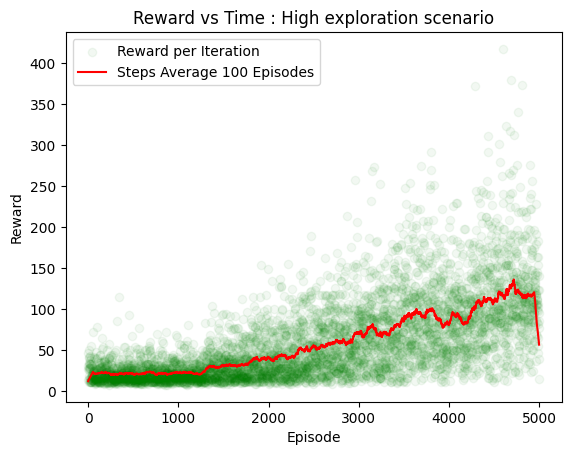


Total time in training: 1:51


In [ ]:

high_exploration_agent = CartPoleAgent(learning_coeff=500, exploration_coeff=1000,graph_title= "Reward vs Time : High exploration scenario",folder_name="high_exploration_agent")


print("Running High Exploration Scenario:")
high_exploration_agent.run_simulation()



<h3>Analyzing High Exploration results</h3>

During the first episodes,from episode 1 to approximately episode 2000, the agent struggles to balance the pole effectively. The average step per 100 episodes remains low, fluctuating at about 20-30 steps. The rewards of the individual episodes are also low and scattered, indicating that this agent is exploring alot but not yet learning stable strategies of how to maintain the pole upright. The red line now begins to rise slowly as the agent gains experience. It reflects some improvement in balancing, but its progress is slow due to a high rate of exploration.

In fact, starting from around episode 2000, the increase in the average step seems more considerable, which suggests that the agent learned better control with time. By episode 3000, the agent is balancing for longer, with an increase in average steps to about 70, continuing upward to peak at around 122 steps by episode 4800. There is still quite a lot of variability in performance, as can be seen from the wide spread of green dots and fluctuations in the red line. Hence, the agent is likely forced to keep trying new actions and cannot converge onto a consistently performing policy with this high of an exploration rate. The graph does show there has been some improvement, yet the success rate remains at 0%. Indeed, this means that during no episode the agent reached the maximum of 500 steps; hence, maybe too high of an exploration rate will not allow the agent to stabilize around an optimal policy.

Running High Exploitation Scenario:


c:\Users\sbokk\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100: Steps taken = 14, Total reward = 14.0, Average steps (last 100) = 22.15
Episode 200: Steps taken = 17, Total reward = 17.0, Average steps (last 100) = 21.77
Episode 300: Steps taken = 11, Total reward = 11.0, Average steps (last 100) = 21.68
Episode 400: Steps taken = 14, Total reward = 14.0, Average steps (last 100) = 23.33
Episode 500: Steps taken = 62, Total reward = 62.0, Average steps (last 100) = 32.83
Episode 600: Steps taken = 27, Total reward = 27.0, Average steps (last 100) = 40.44
Episode 700: Steps taken = 22, Total reward = 22.0, Average steps (last 100) = 49.92
Episode 800: Steps taken = 32, Total reward = 32.0, Average steps (last 100) = 67.93
Episode 900: Steps taken = 20, Total reward = 20.0, Average steps (last 100) = 72.13
Episode 1000: Steps taken = 47, Total reward = 47.0, Average steps (last 100) = 90.42
Episode 1100: Steps taken = 189, Total reward = 189.0, Average steps (last 100) = 99.22
Episode 1200: Steps taken = 42, Total reward = 42.0, Average 

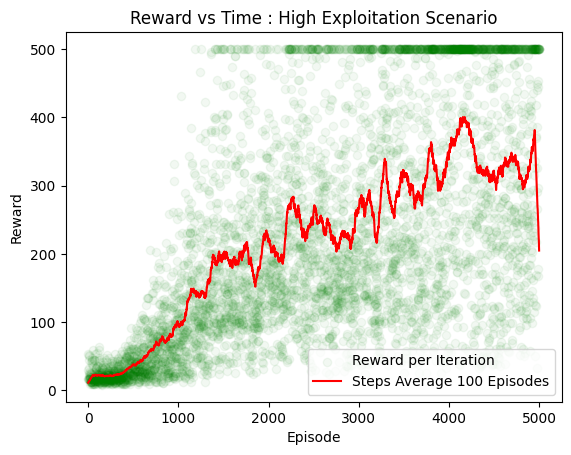


Total time in training: 6:43


In [36]:
high_exploitation_agent = CartPoleAgent(learning_coeff=200, exploration_coeff=200, graph_title= "Reward vs Time : High Exploitation Scenario",folder_name="high_exploitation_agent")

print("Running High Exploitation Scenario:")
high_exploitation_agent.run_simulation()

<h3>Analysis on High Exploitation</h3>
In the early episodes (around episode 1500), the agent starts with low rewards and a low average step count, indicating initial struggles to balance the pole effectively. The logs show that the average steps per 100 episodes remain below 50 for the first 1000 episodes, with the red line (100-episode rolling average of steps) gradually increasing as the agent starts learning a balancing strategy. By episode 1500, the average steps per episode have increased to around 200, with several episodes achieving near-maximum rewards, indicating that the agent is starting to balance the pole successfully for extended periods.

From around episode 1500 onward, the agent's performance becomes more stable, and the rolling average shows consistent improvement, reaching an average of 300-400 steps per episode in later stages. The logs indicate that the agent reaches the maximum reward of 500 steps multiple times, especially after episode 3000, with an increasing number of episodes achieving this maximum as training progresses. By the end of the 5000 episodes, the rolling average remains consistently high, and the agent has a success rate of 15.14%, meaning that it reaches the maximum steps (500 steps) in 15.14% of episodes. This trend suggests that the high exploitation setup allows the agent to focus on the most successful strategies, leading to reliable performance in balancing the pole.

<h3>Scenario Comparisons </h3>

The high exploration scenario, it avoids local optima, but the amount of variability due to this exploration is very high, and convergence is slow. The agent therefore never reaches high rewards or maximum steps consistently. Whereas in the high exploitation scenario, it spends most of its time fine-tuning successful strategies; hence, its learning becomes faster, and there is a more sustained improvement in performance, with high rewards settling into a consistent trend as it repeatedly applies the same lesson. Near-optimal performances can then be realized, with the agent maintaining balance on the pole rather steadily. On the whole, though exploration is the valuation of initial learning, shifting the weight towards exploitation may result in more stable and efficient performance in a task that requires consistent control.

<h2>Learnings throughout the assignment</h2>

Throughout the project, I delved into various concepts and tools that are instrumental in reinforcement learning. One of the key components I explored was the KBinsDiscretizer from the sklearn.preprocessing module.

<b>KBinsDiscretizer:</b> This is a preprocessing technique used to convert a continuous state space into a discrete one. It is particularly useful in scenarios where the reinforcement learning algorithm, such as Q-learning, operates more efficiently with discrete actions and states. By seperating the continuous input range into a set number of bins, the KBinsDiscretizer allows the algorithm to handle complex environments like the CartPole-v1 by simplifying the continuous range of possible states into a manageable, finite set of discrete states.



<h2>Conclusion</h2>

The results from the reinforcement learning agent's performance in the CartPole-v1 environment illustrate the crucial impact of balancing exploration and exploitation.In the exploration versus exploitation scenario within reinforcement learning, the results from the CartPole-v1 simulations suggests that while exploitation can lead to quick initial success, it may hinder the discovery of optimal policies, as seen in the plateauing reward trend. In contrast, an exploration-focused approach, although slower to show results, ultimately fosters a more comprehensive learning process, as evidenced by the consistently improving rewards over time.